In [1]:
# This is a literate code document for experimenting which helps with
# exploring the machine learning aspects before putting essential portions into scripst and final report

# Import libs
import os
import pandas as pd
import numpy as np
import altair as alt
import seaborn as sns
from docopt import docopt
from sklearn import datasets
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import Ridge
from scipy.stats import loguniform
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)

# Reads already-split train and test dfs (80-20%), and creates train and split parts 

train_df = pd.read_csv("../data/processed/train_df.csv")
test_df = pd.read_csv("../data/processed/test_df.csv")

X_train = train_df.drop(columns=["total_cup_points"])
X_test = test_df.drop(columns=["total_cup_points"])

y_train = train_df["total_cup_points"]
y_test = test_df["total_cup_points"]

# Create preprocessor

numeric_features = [
    "moisture",
    "quakers",
    "altitude_mean_meters"
]

categorical_features = [
    "country_of_origin",
    "harvest_year",
    "variety",
    "processing_method",
    "category_one_defects",
    "color",
    "category_two_defects",
    "region"
    ]

preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown="ignore", sparse=False), categorical_features)
)


In [2]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)


# Building regression models

models = {
    "Ridge": Ridge(),
    "RForest_Regressor": RandomForestRegressor(random_state=123)
}

results_dict = {}

for k, v in models.items():
    pipe_multi = make_pipeline(preprocessor, v)
    models_score = mean_std_cross_val_scores(pipe_multi, X_train, y_train, 
                                             cv=5, return_train_score=True)
    results_dict[k] = models_score
    pd.DataFrame.from_dict(results_dict)

# --> FIRST OUTPUT: Table of results of 2 models from CV

pd.DataFrame(results_dict)

# ==> RESULT: We select RF Regressor with better CV performance: 0.177 for R squared 
# ==> NEXT: We try hyperparameter optimization on RF


,Ridge,RForest_Regressor
fit_time,0.009 (+/- 0.006),0.368 (+/- 0.023)
score_time,0.005 (+/- 0.002),0.011 (+/- 0.003)
test_score,-0.065 (+/- 0.594),0.169 (+/- 0.128)
train_score,0.430 (+/- 0.019),0.887 (+/- 0.008)


In [3]:
# Hyperparameter Optimization for RF Regressor Model

param_dist = {'randomforestregressor__max_depth': np.arange(1, 20),
              'randomforestregressor__max_features': np.arange(1, 124),
              'randomforestregressor__n_estimators': np.arange(100, 1000, 100)
             }

pipe = make_pipeline(preprocessor, RandomForestRegressor())

random_search = RandomizedSearchCV(
    pipe, param_distributions=param_dist, n_jobs=-1,
    n_iter=10, cv=5, random_state=123,
    return_train_score=True)

random_search.fit(X_train, y_train)
random_search.best_score_

# ==> RESULT: Hyperparameter optimization ends up with better score of ~ 0.25
# ==> NEXT: We view the feature importance using parameters by this best estimator

0.25170087638584543

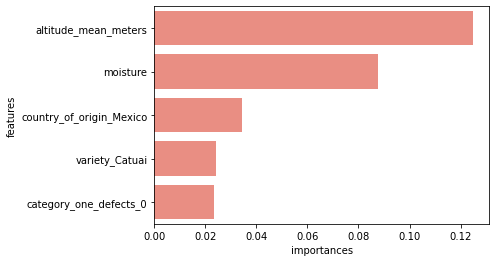

In [4]:
# Inspect important features from best RF model

X_transformed = preprocessor.fit_transform(X_train)

column_names = (
    numeric_features +
    preprocessor.named_transformers_["onehotencoder"].get_feature_names_out().tolist()
)

# Top 5 features
importances = random_search.best_estimator_['randomforestregressor'].feature_importances_
feat_df = pd.DataFrame({'features': column_names, 'importances': importances})
feat_df = feat_df.sort_values('importances', ascending=False)[:5]

# --> SECOND OUTPUT: Barplot of feature importances
sns.barplot(x="importances", y="features", data=feat_df, color="salmon");


In [5]:
# Performance on test set

random_search.score(X_test, y_test)

0.02475563756785293

In [6]:
# DELETE THIS CELL
# --> FIRST OUTPUT: Table of results of 2 models from CV

# results = pd.DataFrame(results_dict)
# results.to_csv("../results/model_comparison.csv")

# ==> RESULT: We select RF Regressor with better CV performance: 0.177 for R squared 
# ==> NEXT: We try hyperparameter optimization on RF


### Classification

In [7]:
train_df = pd.read_csv("../data/processed/train_df.csv")
test_df = pd.read_csv("../data/processed/test_df.csv")

train_df['total_cup_points'] = np.where(train_df['total_cup_points']>82, 'Good', 'Poor')
test_df['total_cup_points'] = np.where(test_df['total_cup_points']>82, 'Good', 'Poor')

X_train = train_df.drop(columns=["total_cup_points"])
X_test = test_df.drop(columns=["total_cup_points"])

y_train = train_df["total_cup_points"]
y_test = test_df["total_cup_points"]

In [8]:
pipe = make_pipeline(preprocessor, RandomForestClassifier())

mean_std_cross_val_scores(pipe, X_train, y_train, cv=10, return_train_score=True, scoring='roc_auc')

fit_time       0.161 (+/- 0.018)
score_time     0.012 (+/- 0.001)
test_score     0.720 (+/- 0.053)
train_score    0.999 (+/- 0.000)
dtype: object

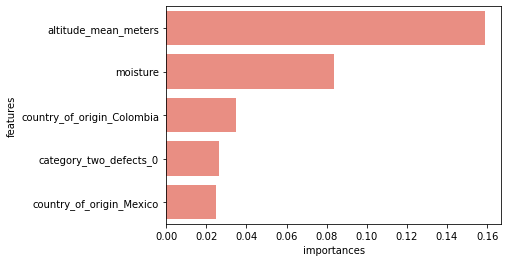

In [9]:
# Inspect important features from best RF model

pipe.fit(X_train, y_train)
pipe['randomforestclassifier'].feature_importances_

column_names = (
    numeric_features +
    preprocessor.named_transformers_["onehotencoder"].get_feature_names_out().tolist()
)

# Top 5 features
importances = pipe['randomforestclassifier'].feature_importances_
feat_df = pd.DataFrame({'features': column_names, 'importances': importances})
feat_df = feat_df.sort_values('importances', ascending=False)[:5]

# --> SECOND OUTPUT: Barplot of feature importances
sns.barplot(x="importances", y="features", data=feat_df, color="salmon");

# References
https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html <br>
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
